# Defasagem Espacial Brasil

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/defasagem_espacial_brasil.ipynb`

## Bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

Requirement already up-to-date: pyshp in /home/walef/anaconda3/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: descartes in /home/walef/anaconda3/lib/python3.7/site-packages (1.1.0)


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from pysal.lib import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

In [21]:
# dados_br.to_csv(r'/home/walef/Dropbox/Mestrado/Dados/dados_multi_spati_teste.csv',index=False, header= True)

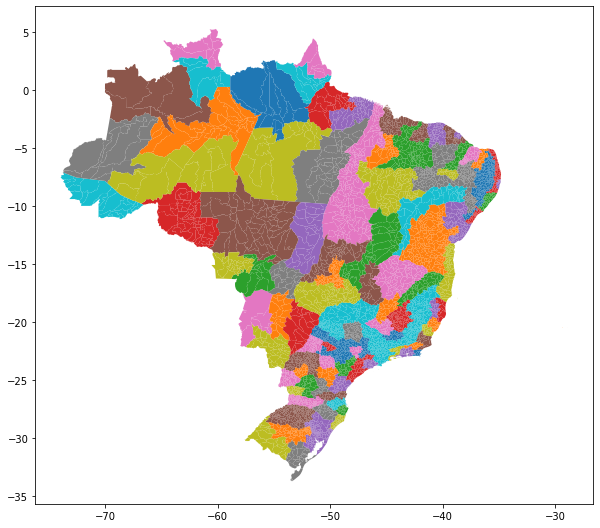

In [22]:
# dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Pesos espaciais - Brasil

In [23]:
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [24]:
dados_br.columns

Index(['uf', 'nome_uf', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry',
       'apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil',
       'total_subvencao_mil', 'valor_indenizacoes_pagas_mil',
       'sinistralidade_media', 'taxa_media', 'apolices_indenizadas'],
      dtype='object')

In [25]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # , 'geometry'
dados_lag = dados_br.drop(retirar, axis = 1)

In [26]:
dados_lag.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [27]:
for variavel in dados_lag.drop(['nome_mun', 'geometry'], axis = 1).columns:
    dados_lag[variavel+'_lag'] = weights.spatial_lag.lag_spatial(w, dados_lag[variavel])

In [28]:
dados_lag = dados_lag.set_index('nome_mun')

In [29]:
dados_lag.head()

,geometry,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
nome_mun,,,,,,,,,,,,,,,,,
alta_floresta_doeste,"POLYGON ((-62.19465 -11.82746, -62.17332 -11.8...",0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ariquemes,"POLYGON ((-62.53648 -9.73222, -62.49559 -9.772...",1.0,2300000.00,18456.81,8305.56,0.0,0.0,8.0,0.0,1.571429,6.208754e+05,38979.591429,15848.868571,5613.112857,621.714286,26.161429,0.285714
cabixi,"POLYGON ((-60.37075 -13.36363, -60.37959 -13.3...",0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,6.000000,4.149398e+06,163459.245000,63393.330000,0.000000,0.000000,107.035000,0.000000
cacoal,"POLYGON ((-61.00080 -11.29737, -61.00302 -11.4...",0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cerejeiras,"POLYGON ((-61.49976 -13.00525, -61.43437 -13.0...",2.0,195143.31,10732.87,4829.80,0.0,0.0,55.0,0.0,1.333333,9.841703e+05,83784.586667,33990.426667,0.000000,0.000000,72.666667,0.000000


## Análise de agrupamento - Defasagem espacial

In [32]:
# subselecionar variáveis
X = dados_lag.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
X = np.asarray(X, dtype=float)
n = X.shape[0]
p = X.shape[1]
# vetor de médias
Xb = np.mean(X, axis=0)
# matriz de covariâncias
S = np.cov(X.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [35]:
Z = linkage(X, method='ward')

In [36]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

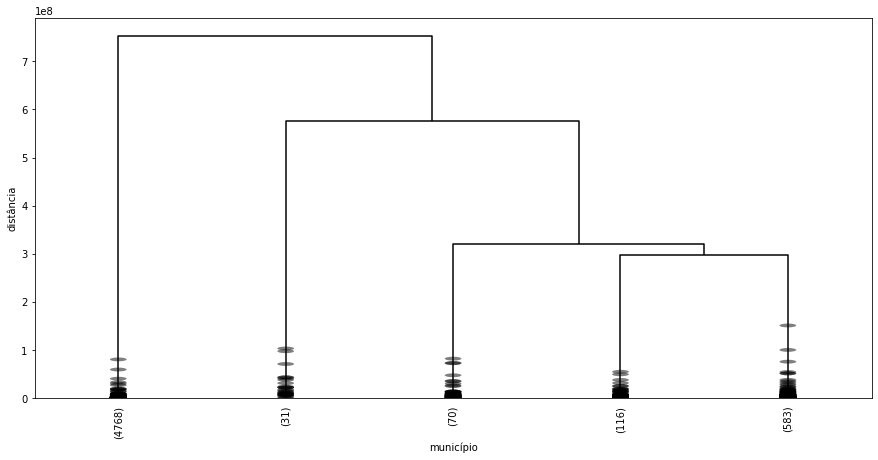

In [37]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [38]:
Z = linkage(X, method='ward')

In [39]:
# definir a distância de corte baseando no dendrograma
max_d = 2e8
grupos = cut_tree(Z, height=max_d)

### Métricas

In [40]:
dados_metrics = dados_lag.drop('geometry', axis=1)

In [41]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

5266.04 0.8 0.77


In [42]:
  # incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_lag['grupo'] = grupos
# moran_matrix.head(2)

In [43]:
# contagem de observações em cada grupo
dados_lag.grupo.value_counts()

0    4768
1     583
2     116
4      70
3      31
Name: grupo, dtype: int64

In [44]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,2.280621,4.003283e+05,2.393300e+04,1.037217e+04,2.022859e+04,791.243219,58.286156,0.399119,5.085350,1.033434e+06,6.460090e+04,2.787364e+04,5.603428e+04,1403.124862,94.869221,1.064669
1,47.639794,8.724848e+06,5.932336e+05,2.564130e+05,6.438594e+05,13095.950017,791.036604,13.653516,61.089216,1.174495e+07,8.261994e+05,3.537479e+05,9.009410e+05,14222.919942,814.957805,17.664724
2,149.431034,3.002787e+07,2.049133e+06,8.765237e+05,1.998691e+06,27206.713621,1532.433103,37.224138,57.483770,1.076256e+07,7.357484e+05,3.150296e+05,8.494077e+05,14089.738081,823.675513,16.647646
3,323.612903,8.552562e+07,6.641238e+06,2.787756e+06,7.171752e+06,40543.769677,1956.611935,112.838710,126.719781,2.719829e+07,2.018202e+06,8.661102e+05,2.602645e+06,18956.891083,984.548084,44.981398
4,80.200000,1.495819e+07,1.030629e+06,4.431819e+05,1.619882e+06,19223.605857,951.897571,31.828571,166.546973,3.971542e+07,2.902521e+06,1.230443e+06,3.050163e+06,26524.230305,1425.780768,51.387245


In [45]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag
grupo,,,,,,,,,,,,,,,,
0,0.0,0.000000e+00,0.00,0.000,0.000,0.000,0.000,0.0,0.500000,1.279380e+05,5.265177e+03,2.312519e+03,0.000000e+00,0.000000,14.015333,0.000000
1,32.0,8.048521e+06,528112.07,225013.460,244626.900,7288.000,505.090,4.0,42.000000,1.148334e+07,7.513517e+05,3.169028e+05,5.316480e+05,9990.310000,577.620000,7.000000
2,125.5,2.652831e+07,1851672.05,767178.925,1266011.635,21064.215,1470.305,17.0,41.964286,1.083782e+07,6.002819e+05,2.576369e+05,4.758014e+05,8776.509444,542.958750,5.464286
3,221.0,7.483142e+07,5905000.65,2570627.390,4837731.450,40118.000,1777.360,50.0,103.500000,3.009621e+07,2.239251e+06,9.094104e+05,1.778526e+06,17270.451250,950.802500,22.875000
4,49.5,1.150786e+07,905815.40,362956.360,425602.385,12950.535,809.755,7.0,152.958333,3.586004e+07,2.489803e+06,1.059685e+06,2.354883e+06,25154.129583,1298.426250,29.250000


### As observações de cada grupo


In [46]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [47]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

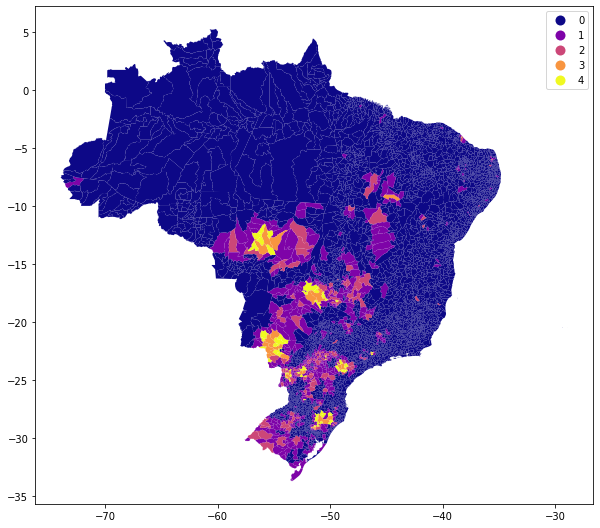

In [48]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'

## K-Médias - Defasagem espacial


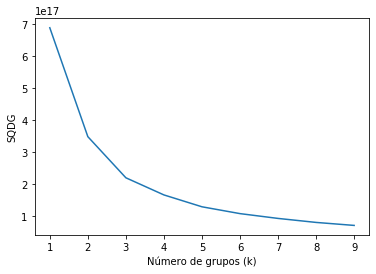

In [49]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_lag.drop('geometry', axis=1))
    dados_lag['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [50]:
k = 4

In [51]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [52]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

5826.14 0.89 0.76


In [53]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_lag['grupo'] = kmeans.labels_

In [54]:
# contagens
dados_lag.grupo.value_counts()

0    4724
2     627
1     189
3      28
Name: grupo, dtype: int64

In [55]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [56]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lag.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,2.420195,4.464958e+05,2.639541e+04,1.142075e+04,2.312644e+04,818.657185,57.523465,0.458933,4.404407,8.882723e+05,5.445062e+04,23502.326549,4.793335e+04,1264.464911,85.109931,0.922357,0.541702
1,142.783069,2.604842e+07,1.820541e+06,7.819488e+05,2.171531e+06,27857.552910,1488.271111,44.349206,123.132475,2.447166e+07,1.732603e+06,740520.475678,2.098110e+06,23473.146951,1263.931483,40.699810,5.343915
2,38.704944,7.420846e+06,4.977997e+05,2.150325e+05,5.111165e+05,10999.202185,696.970526,10.180223,55.760623,1.128931e+07,7.978168e+05,341000.550170,7.910649e+05,13035.419263,777.624304,14.671329,4.933014
3,319.321429,8.898874e+07,6.956963e+06,2.910637e+06,7.115908e+06,40612.884643,1932.434286,106.214286,109.868329,2.666665e+07,1.995036e+06,852489.466026,2.363111e+06,17066.647866,886.287253,37.468988,2.607143


In [57]:
# mediana das variáveis para cada grupo
dados_lag.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,apolices_contratadas_lag,total_segurado_mil_lag,soma_premio_total_mil_lag,total_subvencao_mil_lag,valor_indenizacoes_pagas_mil_lag,sinistralidade_media_lag,taxa_media_lag,apolices_indenizadas_lag,grupos
grupo,,,,,,,,,,,,,,,,,
0,0.0,0.00,0.000,0.00,0.000,0.00,0.00,0.0,0.500000,1.124623e+05,4.615743e+03,2066.248750,0.000000e+00,0.000000,12.901000,0.000000,0
1,119.0,24762875.08,1592996.420,678949.41,1318983.520,26688.70,1454.24,22.0,105.166667,2.142673e+07,1.494197e+06,628919.511667,1.437540e+06,21138.382500,1137.292500,23.000000,7
2,24.0,6538623.07,403547.410,175888.86,123554.610,5072.78,444.41,3.0,41.250000,1.020021e+07,6.860490e+05,293322.455000,4.729469e+05,8917.241667,577.620000,7.000000,5
3,219.5,76597614.84,6318162.755,2664672.34,4812816.415,39270.88,1777.36,47.0,81.660714,3.009065e+07,2.018288e+06,850961.980476,1.662220e+06,16326.046875,832.609107,18.142857,1


In [58]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com defasagem espacial

In [59]:
dados_lag['grupo'] = dados_lag['grupo'].astype('category')

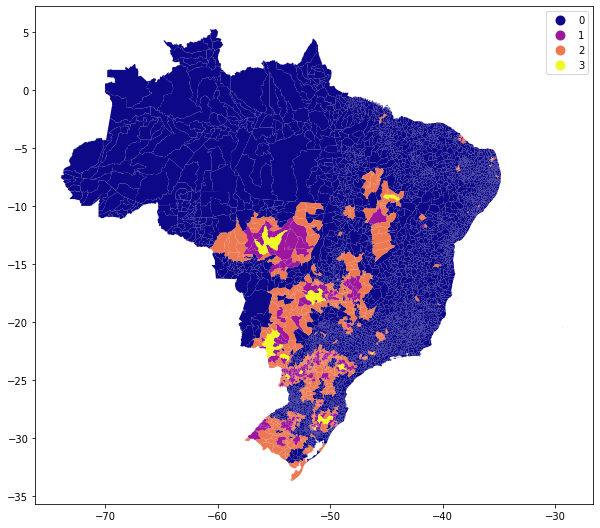

In [60]:
dados_lag.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'